In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats as st

In [263]:
df = pd.read_csv('/datasets/games.csv')
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
Name               16713 non-null object
Platform           16715 non-null object
Year_of_Release    16446 non-null float64
Genre              16713 non-null object
NA_sales           16715 non-null float64
EU_sales           16715 non-null float64
JP_sales           16715 non-null float64
Other_sales        16715 non-null float64
Critic_Score       8137 non-null float64
User_Score         10014 non-null object
Rating             9949 non-null object
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


,Name,Platform,Year_of_Release,Genre,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score,User_Score,Rating
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN


In [264]:
df.columns = ['name', 'platform', 'year_of_release', 'genre', 'na_sales', 'eu_sales',
       'jp_sales', 'other_sales', 'critic_score', 'user_score', 'rating']
df.columns

Index(['name', 'platform', 'year_of_release', 'genre', 'na_sales', 'eu_sales',
       'jp_sales', 'other_sales', 'critic_score', 'user_score', 'rating'],
      dtype='object')

In [265]:
df.info()

#преобразуем столбец year_of_release в тип int, предварительно заменив пропущенные значения на ноль
df['year_of_release'] = df['year_of_release'].fillna(0)
df['year_of_release'] = df['year_of_release'].astype(int)

df['user_score'] = df['user_score'].fillna(0)
df['user_score'] = df['user_score'].replace('tbd', -100) 
df['user_score'] = df['user_score'].astype(float)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
name               16713 non-null object
platform           16715 non-null object
year_of_release    16446 non-null float64
genre              16713 non-null object
na_sales           16715 non-null float64
eu_sales           16715 non-null float64
jp_sales           16715 non-null float64
other_sales        16715 non-null float64
critic_score       8137 non-null float64
user_score         10014 non-null object
rating             9949 non-null object
dtypes: float64(6), object(5)
memory usage: 1.4+ MB



В столбце с оценками пользователей есть значение "tbd", что обозначает "будет определено". Пока что заменим это обозначение на уникальное значение (-100) для удобства.

In [266]:
df.isna().sum()

name                  2
platform              0
year_of_release       0
genre                 2
na_sales              0
eu_sales              0
jp_sales              0
other_sales           0
critic_score       8578
user_score            0
rating             6766
dtype: int64

1. В случае с пропусками в названии все, что можно сделать - это заменить пропущенные значения на 'unknown'
2. Жанр также вряд ли получится восстановить или подобрать, поэтому пропуски в этом столбце также заменяю на 'unknown'
3. Очень много пропусков в столбце с оценками критиков - чуть больше половины от всех данных. Думаю, что если здесь и заменять пропущенные значения, то только на среднее по году, ведь в дальнейшем нам нужно будет выбрать какой то один год и чтобы не портить выборку, сделаю так.
4. Та же история с оценками пользователей, хотя здесь вероятно, что пользователи просто напросто не стали выставлять свои оценки, такое ведь иногда происходит? Оставим пропуски в оценках пользователей как есть, тем более нецелосообразно менять значение tbd(будет определено) на что-то другое и соответственно менять тип столбца.
5. Пропуски в столбце рейтинга скорее всего случайные, но нужно еще посмотреть

In [267]:
df['name'] = df['name'].fillna('unknown')
df.loc[df['name'] == 'unknown']

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
659,unknown,GEN,1993,NaN,1.78,0.53,0.00,0.08,NaN,0.0,NaN
14244,unknown,GEN,1993,NaN,0.00,0.00,0.03,0.00,NaN,0.0,NaN


Здесь же и появились две строки с пропущенными значениями в столбце жанра. Также заменяю их на 'unknown'

In [268]:
df['genre'] = df['genre'].fillna('unknown')

In [269]:
pivot = df.pivot_table(index = 'year_of_release', values = 'critic_score')
def func(x):
    if x in pivot.index:
        return pivot['critic_score'][x]
df['critic_score'] = df['critic_score'].fillna(df['year_of_release'].apply(func))   
df.isna().sum()

name                  0
platform              0
year_of_release       0
genre                 0
na_sales              0
eu_sales              0
jp_sales              0
other_sales           0
critic_score        514
user_score            0
rating             6766
dtype: int64

Пропущенных значений в этом столбце стало значительно меньше, но они все равно остались

Проверим, какие года не вошли в сводную таблицу (просто интересно)

In [270]:
miss_years = []
for x in df['year_of_release']:
    if x not in pivot.index: 
        miss_years.append(x)
        
np.unique(miss_years)


array([1980, 1981, 1982, 1983, 1984, 1986, 1987, 1989, 1990, 1991, 1993,
       1995])

В эти года явно был дефицит критиков или забастовки..

In [271]:
df['rating'].value_counts()
df['rating'] = df['rating'].replace('K-A', 'E')

K-A - это старое название рейтинга E (everyone). 

Оставшиеся пропущенные значения не меняем, потому что предсказать рейтинг наверняка невозможно.


In [272]:
df['all_sales'] = df['na_sales'] + df['jp_sales'] + df['eu_sales']
df.head()

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,all_sales
0,Wii Sports,Wii,2006,Sports,41.36,28.96,3.77,8.45,76.000,8.0,E,74.09
1,Super Mario Bros.,NES,1985,Platform,29.08,3.58,6.81,0.77,59.000,0.0,NaN,39.47
2,Mario Kart Wii,Wii,2008,Racing,15.68,12.76,3.79,3.29,82.000,8.3,E,32.23
3,Wii Sports Resort,Wii,2009,Sports,15.61,10.93,3.28,2.95,80.000,8.0,E,29.82
4,Pokemon Red/Pokemon Blue,GB,1996,Role-Playing,11.27,8.89,10.22,1.00,89.875,0.0,NaN,30.38


### Исследовательский анализ данных

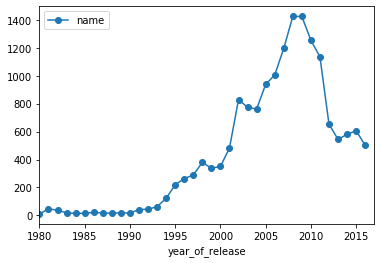

In [273]:
games_sales = df.pivot_table(index = 'year_of_release', values = 'name', aggfunc = 'count')
games_sales = games_sales.reset_index()
games_sales.plot(x = 'year_of_release', y = 'name', xlim = (1980,2017), style = '-o')

Возьмем данные за последние пять лет, примерно с 2010 года наблюдается уменьшение продаж на видеоигры, могли поменяться  предпочтения целевой аудитории. Из-за этого нецелесообразно брать весь объем изначальных данных. 

In [274]:
top_platform_sales = df.pivot_table(index = 'platform', values = 'all_sales', aggfunc = 'sum')
                     
top_platform_sales = top_platform_sales.sort_values(by = 'all_sales',ascending = False)
top_platform_sales = top_platform_sales.head(10)
top_platform_sales #платформы с наибольшими суммарными продажами

,all_sales
platform,
PS2,1062.33
X360,885.66
Wii,828.44
PS3,803.97
DS,746.86
PS,689.95
GBA,310.12
PS4,265.79
PSP,252.63


In [275]:
platform_sales = df.pivot_table(index = ['platform', 'year_of_release'], values = 'all_sales', aggfunc = 'sum')  
                 
platform_sales.head() #как менялись продажи по платформам и годам

all_sales
platform year_of_release           
2600     0                    10.43
         1980                 11.26
         1981                 35.36
         1982                 28.57
         1983                  5.78

In [276]:
platform_sales = platform_sales.reset_index()
platform_sales.head()

,platform,year_of_release,all_sales
0,2600,0,10.43
1,2600,1980,11.26
2,2600,1981,35.36
3,2600,1982,28.57
4,2600,1983,5.78


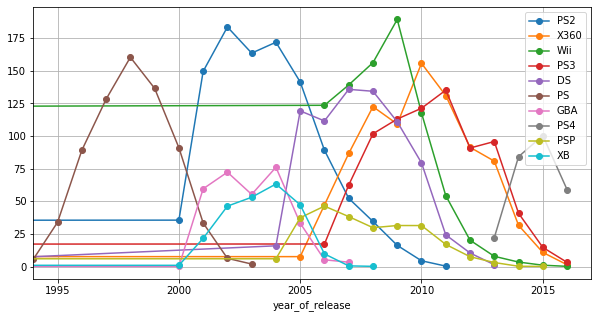

In [277]:
fig, axs = plt.subplots(1,1, figsize = (10,5))
for plat in top_platform_sales.index:
    (platform_sales
         .query('platform == @plat')
         .plot(ax=axs, x = 'year_of_release', y = 'all_sales', grid = True, xlim = (1994,2017), style = 'o-')
    )
plt.legend(top_platform_sales.index)

1. Новые платформы появляются примерно раз в 3-4 года, но при этом в один год может появиться несколько новых платформ. 
2. Исчезают они не так быстро - около 7-9 лет, но, чем современнее технология, тем дольше она сохраняет свою актуальность, например, psp не на высоких позициях, но все таки продержалась, около 11 лет.

Исходя из полученных графиков, можно сказать, что:
1. В настоящее время существует серьезный спад спроса на видеоигры
2. "Цикл жизни" многих платформ подходит к концу, поэтому скорее всего нужно ожидать анонса новых 
3. Единственная платформа, продажи которой к 2016 году не сравнялись с нулем - это PS4, что обусловлено ее недавним выходом 

Выбираем актуальный период для дальнейшего построения прогноза


In [278]:
data = df.query('year_of_release >= 2010')
data = data.reset_index(drop = True)
data.head()

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,all_sales
0,Kinect Adventures!,X360,2010,Misc,15.00,4.89,0.24,1.69,61.000,6.3,E,20.13
1,Grand Theft Auto V,PS3,2013,Action,7.02,9.09,0.98,3.96,97.000,8.2,M,17.09
2,Grand Theft Auto V,X360,2013,Action,9.66,5.14,0.06,1.41,97.000,8.1,M,14.86
3,Pokemon Black/Pokemon White,DS,2010,Role-Playing,5.51,3.17,5.65,0.80,67.482,0.0,NaN,14.33
4,Call of Duty: Modern Warfare 3,X360,2011,Shooter,9.04,4.24,0.13,1.32,88.000,3.4,M,13.41


Как и говорилось выше, берем данные за пять последних лет, чтобы не потерять динамику

In [279]:
games_platform = data.pivot_table(index = ['platform','name'], values = 'all_sales', aggfunc = 'sum')
games_platform = games_platform.reset_index()
games_platform.head()

,platform,name,all_sales
0,3DS,Beyblade Burst,0.03
1,3DS,Fire Emblem Fates,1.56
2,3DS,Frozen: Olaf's Quest,0.54
3,3DS,Haikyu!! Cross Team Match!,0.04
4,3DS,12-Sai. Honto no Kimochi,0.07


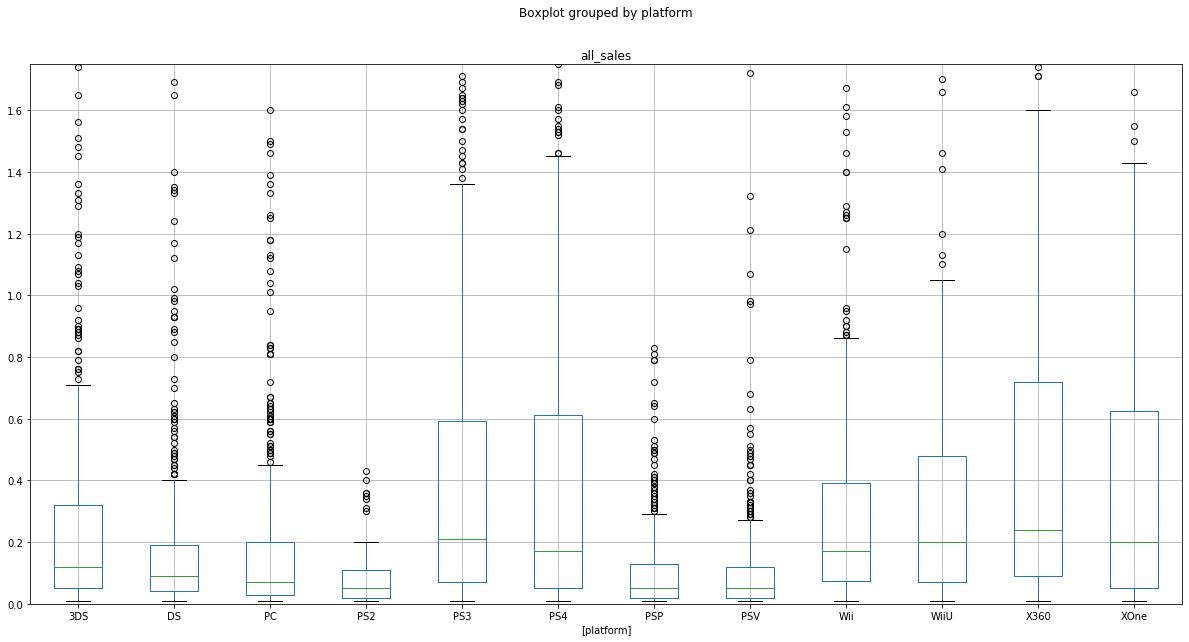

In [280]:
games_platform.boxplot(by = 'platform', figsize = (20,10))
plt.ylim(0,1.75)
plt.show()

1. Разница в продажах ощутима - достаточно взглянуть  на разницу ящиков X360 и PS2
2. Средние продажи разных платформ не так сильно отличаются, но все же различия есть

Как влияют на продажи внутри одной популярной платформы отзывы пользователей и критиков?


In [281]:
data_ps2 = data.query('platform == "PS2"')[['name','platform','critic_score','user_score','all_sales']]
data_ps2.corr()['all_sales']

critic_score    0.236561
user_score     -0.231383
all_sales       1.000000
Name: all_sales, dtype: float64

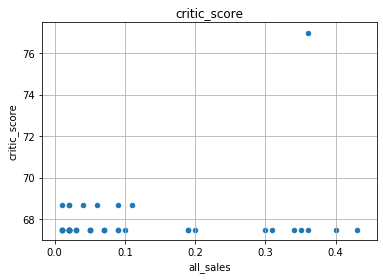

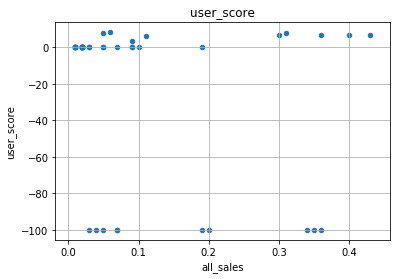

In [282]:
data_ps2.plot(x = 'all_sales', y = 'critic_score', kind = 'scatter', title = 'critic_score', grid = True)
data_ps2.plot(x = 'all_sales', y = 'user_score', kind = 'scatter', title = 'user_score', grid = True)
#.plot(x='height', y='weight', kind='scatter')

Для оценки влияния отзывов на продажи внутри платформы взяла сначала самую популярную платформу из топа - PS2. Несмотря на то, что продажи игр на этой платформе приблизились к нулю еще до 2016 года, она остается платформой с самым высоким уровнем продаж.
1. Корреляция продаж с оценкой критиков положительная (чем выше оценка, тем выше продажи), но совсем не высокая, здесь можно сказать, что связь либо очень слабая, либо отсутствует вообще
2. Аналогичная история с оценками пользователей - слабая или отсутствующая связь, несмотря на это здесь корреляция положительная, то есть значения прямо пропорциональны
3. На первом графике, оценка критиков, можно увидеть, что несмотря на один уровень оценки игры, продажи могут быть любыми
4. На втором графике не смотрим на значения (-100), эти значения бывшие "tbd" (игры ожидающие оценки), также здесь много нулевых оценок, но вывод аналогичный п.3 - вне зависимости от оценки пользователей, игра может собрать и меньше 0.1млн долларов и больше 0.1 млн.долларов. 

Соотношение выводов


In [283]:
for x in data['platform'].unique():
    print('Корреляция для платформы', x)
    print(data
        .query('platform == @x')[['name','platform','critic_score','user_score','all_sales']]
        .corr()['all_sales'])
    print()    

Корреляция для платформы X360
critic_score    0.308203
user_score      0.117428
all_sales       1.000000
Name: all_sales, dtype: float64

Корреляция для платформы PS3
critic_score    0.360685
user_score      0.138430
all_sales       1.000000
Name: all_sales, dtype: float64

Корреляция для платформы DS
critic_score    0.075457
user_score      0.087067
all_sales       1.000000
Name: all_sales, dtype: float64

Корреляция для платформы PS4
critic_score    0.324360
user_score      0.085115
all_sales       1.000000
Name: all_sales, dtype: float64

Корреляция для платформы 3DS
critic_score    0.184049
user_score      0.113510
all_sales       1.000000
Name: all_sales, dtype: float64

Корреляция для платформы Wii
critic_score    0.221573
user_score      0.203555
all_sales       1.000000
Name: all_sales, dtype: float64

Корреляция для платформы XOne
critic_score    0.348259
user_score      0.133740
all_sales       1.000000
Name: all_sales, dtype: float64

Корреляция для платформы WiiU
critic_sco

1. Обратно пропорциональны продажи игр оценкам пользователей только на платформах PS2 и PSP.
2. В случае с PSP корреляция незначительна, соответственно отсутствует
3. Сильная прямая связь между уровнем продаж и оценками критиков видна на таких платформах как:
    - X360
    - PS3
    - PS4
    - Xone
    - WiiU
    - PC
4. Все остальные корреляции находятся в диапазоне [-0.3;0.3], их можно считать незначительными
5. Можно предположить, что в случае с большинством платформ оценка критиков является более значимой, нежели оценка пользователей. Возможно, это обусловлено тем, что пользователи, оставившие отзыв уже купили игру.

Общее распределение игр по жанрам. 

In [ ]:
data['genre'].value_counts()
data_genres = data.pivot_table(index = 'genre', values = 'all_sales', aggfunc = 'sum')
data_genres = data_genres.reset_index()
data_genres = data_genres.sort_values(by = 'all_sales', ascending = False).reset_index(drop = True)

print('Самые высокие продажи у жанра', data_genres['genre'][0], 'составили', data_genres['all_sales'][0],'млн.долларов')
print('Самые низкие продажи у жанра', data_genres['genre'][11], 'составили', data_genres['all_sales'][11],'млн.долларов')
print('Разница в доходе от самого прибыльного жанра и самого неприбыльного составила', data_genres['all_sales'][0] - data_genres['all_sales'][11])
data_genres

1. Самыми прибыльными жанрами однозначно можно назвать экшн и шутер
2. Жанры, которые заняли позиции 2-7 включительно можно назвать жанрами со средней прибылью
3. Жанры, чьи продажи составили меньше 70млн.долларов можно отнести в третью группу - жанры с самой низкой доходностью

#### Портрет пользователя каждого региона

In [285]:
data_na_genre = (data
           .pivot_table(index = 'genre', values = 'na_sales', aggfunc = 'sum')
           .sort_values(by = 'na_sales', ascending = False)
           .head(5)
           .reset_index()
          )
data_eu_genre = (data
           .pivot_table(index = 'genre', values = 'eu_sales', aggfunc = 'sum')
           .sort_values(by = 'eu_sales', ascending = False)
           .head(5)
           .reset_index()
          )
data_jp_genre = (data
           .pivot_table(index = 'genre', values = 'jp_sales', aggfunc = 'sum')
           .sort_values(by = 'jp_sales', ascending = False)
           .head(5)
           .reset_index()
          )

In [286]:
data_regions = data_na_genre.copy()
data_regions.columns = ['genres_na','na_sales']

data_regions['genres_eu'] = data_eu_genre['genre']
data_regions['eu_sales'] = data_eu_genre['eu_sales']

data_regions['genres_jp'] = data_jp_genre['genre']
data_regions['jp_sales'] = data_jp_genre['jp_sales']
print('na_sales', data_regions['na_sales'].sum())
print('eu_sales', data_regions['eu_sales'].sum())
print('jp_sales', data_regions['jp_sales'].sum())

data_regions

na_sales 920.7699999999984
eu_sales 663.4900000000009
jp_sales 231.51000000000008


,genres_na,na_sales,genres_eu,eu_sales,genres_jp,jp_sales
0,Action,290.64,Action,233.63,Role-Playing,103.54
1,Shooter,237.47,Shooter,171.45,Action,72.20
2,Sports,156.81,Sports,116.84,Misc,24.29
3,Misc,123.80,Role-Playing,75.48,Platform,15.81
4,Role-Playing,112.05,Misc,66.09,Adventure,15.67


1. Топ жанров в Северной Америке почти такой же, как и Европе. Отличаются только два последних элемента : Misc, Role-Playing
2. Самые низкие продажи игр приходятся на Японию, примерно 20% от продаж в Северной Америке, выше в Европе, около 2/3 от продаж в Северной Америке, ну и соответственно самые высокие - в Северной Америке, почти 921млн.
3. Такое различие может быть обусловлено различием культур. Культура Европы более схожа с культурой Америки, нежели с культурой Японии.
4. Несмотря на различия, жанр экшн занимает лидирующие строки во всех странах 

 - Самые популярные платформы (топ-5)


In [287]:
data_na_platforms = (data
           .pivot_table(index = 'platform', values = 'na_sales', aggfunc = 'sum')
           .sort_values(by = 'na_sales', ascending = False)
           .head(5)
           .reset_index()
          )
data_eu_platforms = (data
           .pivot_table(index = 'platform', values = 'eu_sales', aggfunc = 'sum')
           .sort_values(by = 'eu_sales', ascending = False)
           .head(5)
           .reset_index()
          )
data_jp_platforms = (data
           .pivot_table(index = 'platform', values = 'jp_sales', aggfunc = 'sum')
           .sort_values(by = 'jp_sales', ascending = False)
           .head(5)
           .reset_index()
          )

In [288]:
data_platforms = data_na_platforms.copy()
data_platforms.columns = ['na_platform','na_sales']

data_platforms['eu_platform'] = data_eu_platforms['platform']
data_platforms['eu_sales'] = data_eu_platforms['eu_sales']

data_platforms['jp_platform'] = data_jp_platforms['platform']
data_platforms['jp_sales'] = data_jp_platforms['jp_sales']

print('na_sales', data_platforms['na_sales'].sum())
print('eu_sales', data_platforms['eu_sales'].sum())
print('jp_sales', data_platforms['jp_sales'].sum())

data_platforms

na_sales 886.4900000000002
eu_sales 652.8300000000021
jp_sales 251.82000000000045


,na_platform,na_sales,eu_platform,eu_sales,jp_platform,jp_sales
0,X360,334.18,PS3,213.60,3DS,100.62
1,PS3,229.25,X360,163.41,PS3,59.26
2,Wii,121.20,PS4,141.09,PSP,42.20
3,PS4,108.74,PC,68.82,DS,27.90
4,XOne,93.12,Wii,65.91,PSV,21.84


- Влияет ли рейтинг ESRB на продажи в отдельном регионе?

In [289]:
data_na_esrb = (data
           .pivot_table(index = 'rating', values = 'na_sales', aggfunc = 'sum')
           .sort_values(by = 'na_sales', ascending = False)
           .reset_index()
          )
data_eu_esrb = (data
           .pivot_table(index = 'rating', values = 'eu_sales', aggfunc = 'sum')
           .sort_values(by = 'eu_sales', ascending = False)
           .reset_index()
          )
data_jp_esrb = (data
           .pivot_table(index = 'rating', values = 'jp_sales', aggfunc = 'sum')
           .sort_values(by = 'jp_sales', ascending = False)
           .reset_index()
          )

In [290]:
data_esrb = data_na_esrb.copy()
data_esrb.columns = ['na_esrb','na_sales']

data_esrb['eu_esrb'] = data_eu_esrb['rating']
data_esrb['eu_sales'] = data_eu_esrb['eu_sales']

data_esrb['jp_esrb'] = data_jp_esrb['rating']
data_esrb['jp_sales'] = data_jp_esrb['jp_sales']

print('na_sales', data_esrb['na_sales'].sum())
print('eu_sales', data_esrb['eu_sales'].sum())
print('jp_sales', data_esrb['jp_sales'].sum())

data_esrb

na_sales 974.6899999999983
eu_sales 701.7699999999993
jp_sales 133.65000000000018


,na_esrb,na_sales,eu_esrb,eu_sales,jp_esrb,jp_sales
0,M,382.22,M,292.04,E,47.87
1,E,271.15,E,197.34,T,42.11
2,T,160.81,T,113.08,M,30.45
3,E10+,159.38,E10+,99.28,E10+,13.22
4,EC,1.13,RP,0.03,EC,0.00
5,RP,0.00,EC,0.00,RP,0.00


1. После того, как мы отбросили данные старше 2010 года, осталось всего 6 видов рейтинга
2. Первые три позиции во всез регионах занимают игры с рейтингом "для всех", "подросткам","для взрослых"
3. Топ рейтингов в Северной Америке и в Европе опять отличаются только на два последних элемента - "для детей младшего возраста" и "рейтинг ожидается" 
4. В Японии и Европе, судя по результатам, детям играть не разрешают и без рейтинга ничего не покупают
5. В Северной Америке иногда покупают игры детям, но также, как и в Японии игры без рейтинга не берут
6. На четвертой позиции во всех регионах занимает рейтинг "для всех от 10+ лет"
7. Даже суммарно люди в Японии не покупают столько игр, сколько тратят американцы или европейцы на игры для взрослых

##### Проверка гипотез

- Средние пользовательские рейтинги платформ Xbox One и PC одинаковые

In [291]:
#Средние пользовательские рейтинги платформ Xbox One и PC не одинаковые = H0
#Средние пользовательские рейтинги платформ Xbox One и PC одинаковые = H1

alpha = 0.05

raiting_xbox = data.query('platform == "XOne"')['user_score']
raiting_pc = data.query('platform == "PC"')['user_score']

result = st.ttest_ind(
    raiting_xbox,
    raiting_pc,
    equal_var = False)
print('p-значение', result.pvalue)

if result.pvalue > alpha :
    print('Не получилось отвергнуть нулевую гипотезу')
else: 
    print('Отвергаем нулевую гипотезу')

p-значение 0.8761749347162752
Не получилось отвергнуть нулевую гипотезу


1. Нужно проверить гипотезу о равенстве средних двух генеральных совокупностей, значит использую метод st.ttest_ind()
2. Нулевая гипотеза обычно говорит о том, что какой либо связи не существует, значит в данном случае за нулевую гипотезу берем высказывание о том, что рейтинги НЕ одинаковые
2. Значение p-value достаточно велико, чтобы утверждать, что рейтинги платформ Xbox One и PC категорически разные

 - Средние пользовательские рейтинги жанров Action (англ. «действие») и Sports (англ. «виды спорта») разные

In [292]:
#Средние пользовательские рейтинги жанров Action (англ. «действие») и Sports (англ. «виды спорта») разные = H0
#Средние пользовательские рейтинги жанров Action (англ. «действие») и Sports (англ. «виды спорта») одинаковые = H1

alpha = 0.05

raiting_action = data.query('genre == "Action"')['user_score']
raiting_sports = data.query('genre == "Sports"')['user_score']

result = st.ttest_ind(
    raiting_action,
    raiting_sports,
    equal_var = False)
print('p-значение', result.pvalue)

if result.pvalue > alpha :
    print('Не получилось отвергнуть нулевую гипотезу')
else: 
    print('Отвергаем нулевую гипотезу')

p-значение 1.581435156357556e-09
Отвергаем нулевую гипотезу


1. В данном случае опять стоит задача о равенстве средних двух генеральных совокупностей
2. Нулевая гипотеза здесь формируется по тому же принципу, что и в предыдущем задании 
3. Судя по значению p-value можно сказать, что средние пользовательские рейтинги жанров Action и Sports примерно равны


##### Общий вывод


1. Для разных регионов должны быть разные рекламные кампании. То, что рекламируется в Европе или в Северной Америке, исходя из иследований точно не сможет привлечь внимание целевой аудитории в Японии
2. Имеет смысл разрабатывать игры на платформе PS4, это единственная платформа, для которой еще сравнительно активно покупают игры
3. Можно попробовать "возродить" те платформы, которые к 2016 году оказались в яме, но здесь есть серьезные риски. Это такие платформы, как:
    - PS3
    - Xbox360
    - PSP
    - Wii
4. При создании игры на платформе PS4 надо обязательно обратить внимание, что на продажи такой игры сильно влияют оценки критиков
5. Основная ориентированность может быть на аудиторию Северной Америки и Европы- именно там чаще всего покупают игры
6. При желании повысить доход от продаж, нужно уделить внимание Японии в жанре Role-Playing на платформе 3DS или PS3, учитывая, что самые популярные рейтинги этого региона - "E","M","T"  
7. Публика в Америке и в Европе более неприхотливая - в приоритете у них игры жанра Action и Shooter на платформах PS и Xbox